https://www.kaggle.com/minhtriet/a-beginner-guide-for-sale-data-prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, date
from dateutil.relativedelta import relativedelta

from sklearn.preprocessing import StandardScaler

from math import ceil

from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [2]:
train = pd.read_csv('../input/sales_train.csv')
test = pd.read_csv('../input/test.csv')

items = pd.read_csv('../input/items.csv')
item_cats = pd.read_csv('../input/item_categories.csv')
shops = pd.read_csv('../input/shops.csv')

In [3]:
test_shops = test.shop_id.unique()
train = train[train.shop_id.isin(test_shops)]
test_items = test.item_id.unique()
train = train[train.item_id.isin(test_items)]

In [4]:
MAX_BLOCK_NUM = train.date_block_num.max() #33
MAX_ITEM = len(test_items)
MAX_CAT = len(item_cats)
MAX_YEAR = 3
MAX_MONTH = 4
MAX_SHOP = len(test_shops)

# Data Exploration
shop & item categories 두 관점에서 보겠다

## shop_id

In [5]:
grouped = pd.DataFrame(train.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum().reset_index()) #shop_id 별로 월별 판매량
grouped.head(3)

,shop_id,date_block_num,item_cnt_day
0,2,0,248.0
1,2,1,135.0
2,2,2,237.0


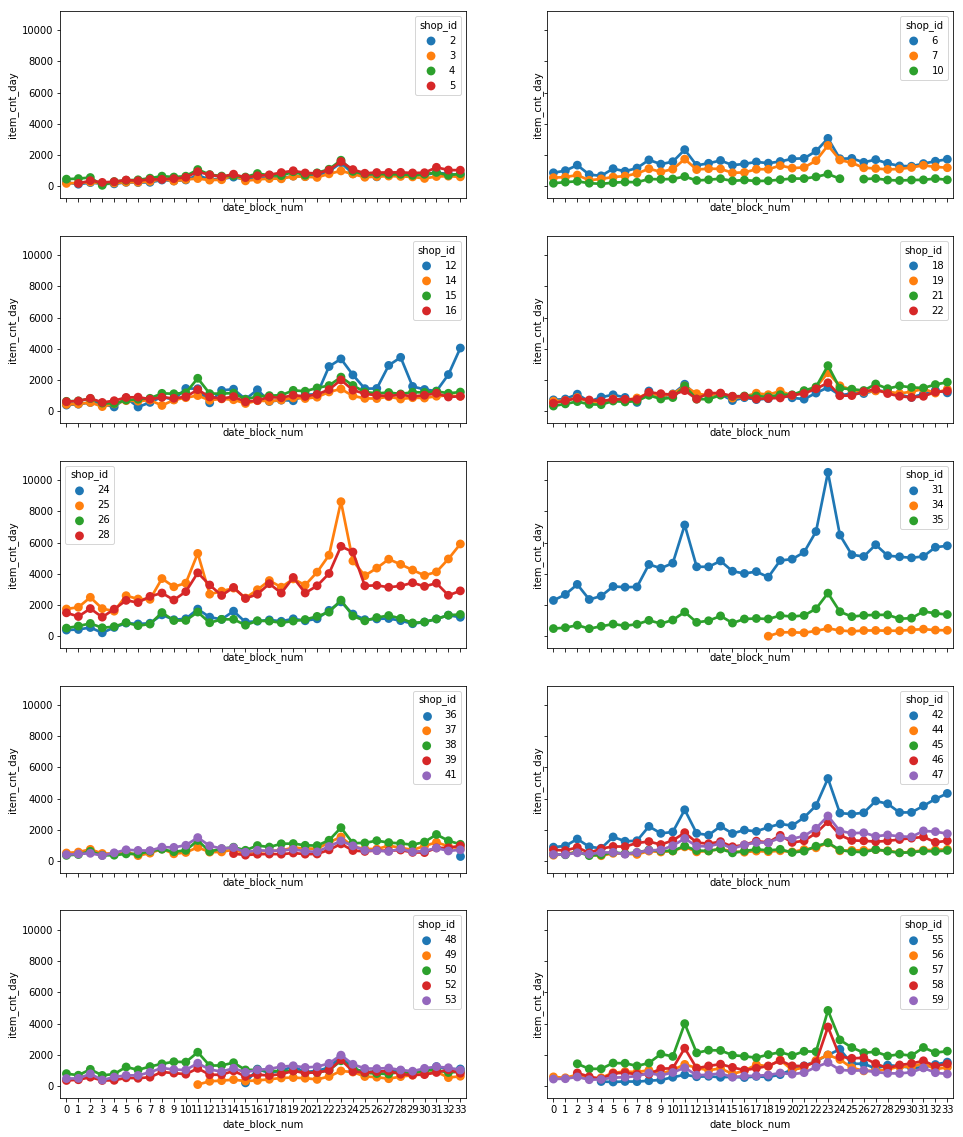

In [6]:
fig, axes = plt.subplots(nrows = 5, ncols = 2, sharex=True, sharey = True, figsize = (16,20)) #축 공유
num_graph = 10
id_per_graph = ceil(grouped.shop_id.max() / num_graph) #6
count = 0

for i in range(5) :
    for j in range(2) :
        sns.pointplot(x = 'date_block_num', y = 'item_cnt_day', hue = 'shop_id', data = grouped[np.logical_and(count * id_per_graph <= grouped['shop_id'],
                                                                                                               grouped['shop_id'] < (count + 1)*id_per_graph)], ax = axes[i][j])
        count += 1

데이터의 시작이 2013년 1월부터 시작이다. 확실히 연말에 피크 생긴다. 그러므로, 월과 연도를 추가하여 패턴을 파악하도록 하는 것이 좋겠다. 각가의 아템 판매양이 어떻게 되는지 보는 것이 좋겠다. item category도 함께!

## item categories

In [7]:
train = train.set_index('item_id').join(items.set_index('item_id')).drop('item_name', axis = 1).reset_index()
train.head(3)

,item_id,date,date_block_num,shop_id,item_price,item_cnt_day,item_category_id
0,30,28.02.2013,1,50,399.0,1.0,40
1,30,26.02.2013,1,50,399.0,1.0,40
2,30,12.02.2013,1,50,399.0,1.0,40


In [8]:
train['month'] = train.date.apply(lambda x: datetime.strptime(x, '%d.%m.%Y').strftime('%m'))
train['year'] = train.date.apply(lambda x: datetime.strptime(x, '%d.%m.%Y').strftime('%Y'))

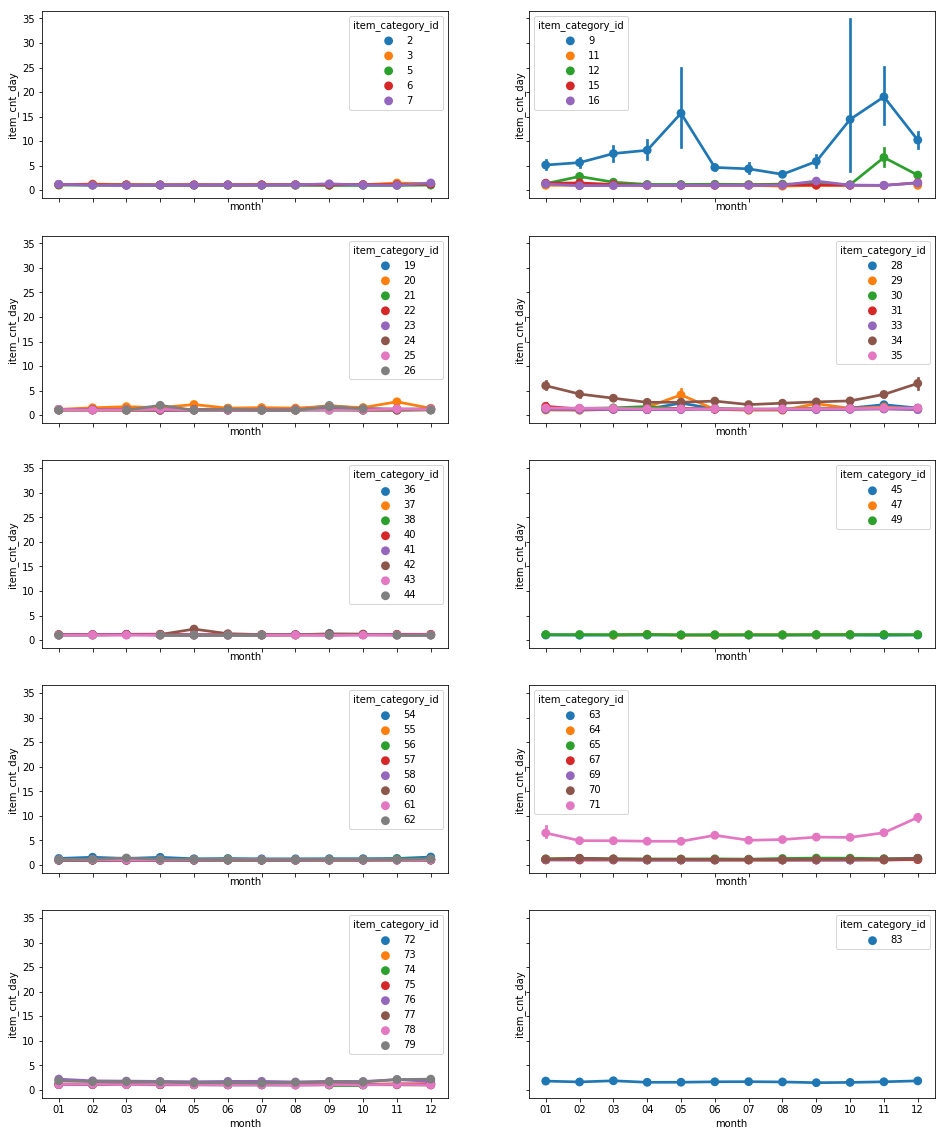

In [9]:
fig, axes = plt.subplots(nrows = 5, ncols = 2, sharex = True, sharey = True, figsize = (16,20))
num_graph = 10
id_per_graph = ceil(train.item_category_id.max() / num_graph)
count = 0

for i in range(5) :
    for j in range(2) :
        sns.pointplot(x = 'month', y = 'item_cnt_day', hue = 'item_category_id',
                     data = train[np.logical_and(count * id_per_graph <= train.item_category_id, train['item_category_id'] < (count + 1) * id_per_graph)], ax = axes[i][j])
        count += 1

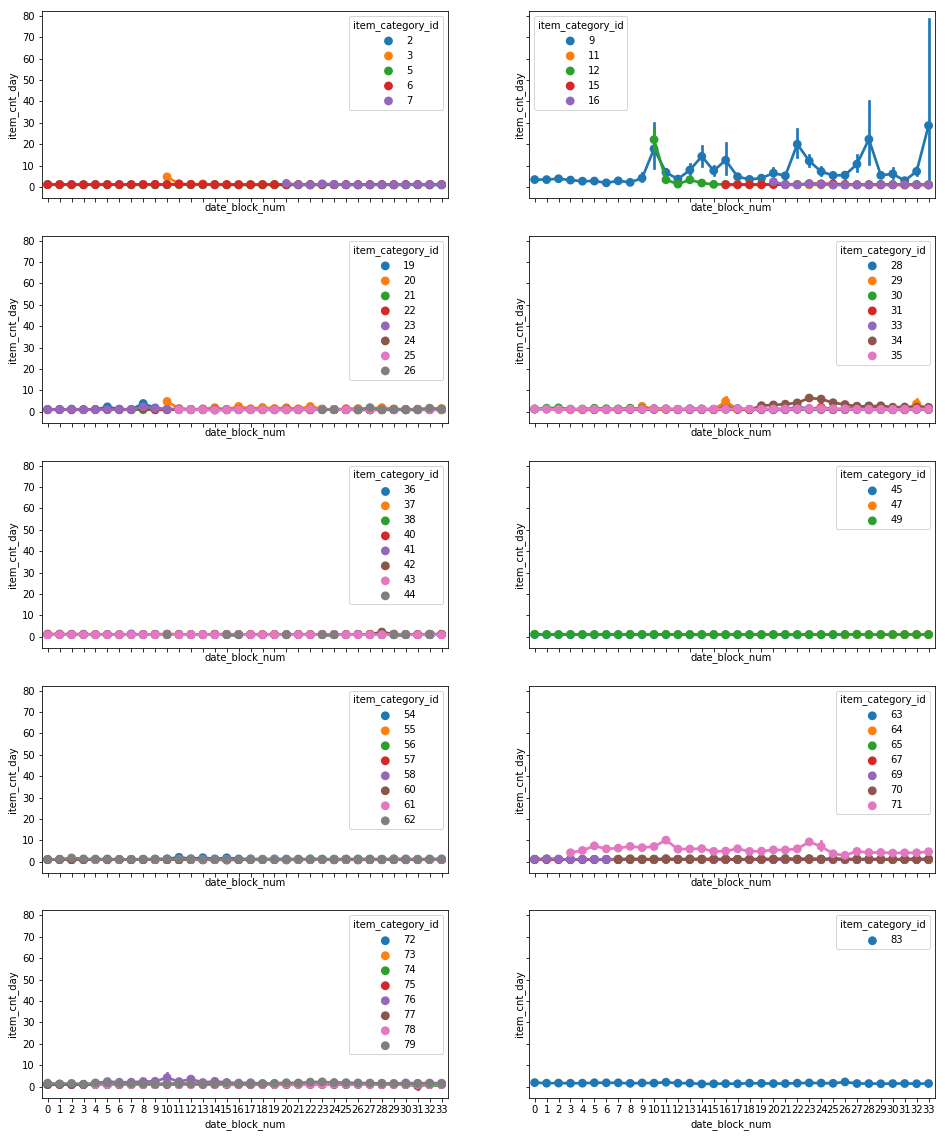

In [10]:
fig, axes = plt.subplots(nrows = 5, ncols = 2, sharex = True, sharey = True, figsize = (16,20))
num_graph = 10
id_per_graph = ceil(train.item_category_id.max() / num_graph)
count = 0

for i in range(5) :
    for j in range(2) :
        sns.pointplot(x = 'date_block_num', y = 'item_cnt_day', hue = 'item_category_id',
                     data = train[np.logical_and(count * id_per_graph <= train.item_category_id, train['item_category_id'] < (count + 1) * id_per_graph)], ax = axes[i][j])
        count += 1

In [11]:
train.head(3)

,item_id,date,date_block_num,shop_id,item_price,item_cnt_day,item_category_id,month,year
0,30,28.02.2013,1,50,399.0,1.0,40,02,2013
1,30,26.02.2013,1,50,399.0,1.0,40,02,2013
2,30,12.02.2013,1,50,399.0,1.0,40,02,2013


In [12]:
train = train.drop(['date', 'item_category_id'], axis = 1)
train = train.groupby(['shop_id', 'item_id', 'date_block_num', 'month', 'year']).sum()
train = train.sort_index()
train.head(3)

item_price  item_cnt_day
shop_id item_id date_block_num month year                          
2       30      2              03    2013       359.0           1.0
                5              06    2013       399.0           1.0
                15             04    2014       169.0           1.0

# Training

In [13]:
scaler = StandardScaler()
cnt_scaler = StandardScaler()

scaler.fit(train.item_price.as_matrix().reshape(-1,1))
cnt_scaler.fit(train.item_cnt_day.as_matrix().reshape(-1,1))

train.item_price = scaler.transform(train.item_price.as_matrix().reshape(-1,1))
train.item_cnt_day = scaler.transform(train.item_cnt_day.as_matrix().reshape(-1,1))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


모든 데이터를 training하는 것이 자연스럽지만, 두가지 결점이 있다
- 2013년 1월 데이터(date_block_num = 0) 가 예측해야 할 데이(2015 11월) 영향이 미미
- 메모리 에러 ㅜㅜ

**2013,2014 7,8,9,10,11 데이터를 활용**

# Missing Data
- 모든 아이템들이 위 기간에 팔리지는 않았기 때문에 빈 값은 item_cnt_day = 0으로 채운다.
- item의 가격은 shop과 산 시점에 따라 다르다. 가격은 가장 가까운 과거의 데이터로 채운다.

In [14]:
train.reset_index().groupby(['item_id', 'date_block_num', 'shop_id']).mean()

item_price  item_cnt_day
item_id date_block_num shop_id                          
30      1              3         -0.072265     -0.299289
                       4          0.041532     -0.298862
                       5         -0.072265     -0.299147
                       6          0.314142     -0.295867
                       7          0.149626     -0.298434
                       10        -0.186490     -0.299289
                       12        -0.242961     -0.299717
                       14         0.149626     -0.298719
                       15         0.208426     -0.297578
                       16         0.097005     -0.297578
                       18        -0.072265     -0.299004
                       19         0.152478     -0.297721
                       21         0.098431     -0.298006
                       22         0.041532     -0.298576
                       24         0.326026     -0.297721
                       25         0.439823     -0.293015
                       26         0.316329     -0.296722
                       28         0.661704     -0.291446
                       31         0.665965     -0.283888
                       35         0.142971     -0.297578
                       37         0.212228     -0.297721
                       38         0.098431     -0.298719
                       41        -0.186062     -0.299575
                       42         0.548283     -0.293300
                       44         0.269127     -0.297293
                       45        -0.015366     -0.299004
                       46         0.382925     -0.296865
                       47         0.089854     -0.298434
                       50         0.494821     -0.295724
                       52        -0.129164     -0.299147
...                                    ...           ...
22167   30             52        -0.214583     -0.299575
        31             2         -0.257221     -0.299717
                       12        -0.129306     -0.299289
                       22         0.041247     -0.298006
                       25        -0.214583     -0.299575
                       26        -0.257221     -0.299717
                       31        -0.257221     -0.299717
                       35        -0.257221     -0.299717
                       39        -0.257221     -0.299717
                       42        -0.171945     -0.299432
                       52        -0.214583     -0.299575
        32             12        -0.044030     -0.299004
                       21        -0.214583     -0.299575
                       22        -0.129306     -0.299289
                       24        -0.257221     -0.299717
                       25        -0.129306     -0.299289
                       42        -0.171945     -0.299289
        33             6         -0.257221     -0.299717
                       10        -0.277756     -0.299717
                       12        -0.001391     -0.298862
                       18        -0.257221     -0.299717
                       21        -0.257221     -0.299717
                       22         0.162767     -0.297863
                       25        -0.214583     -0.299432
                       26        -0.257221     -0.299717
                       28        -0.257221     -0.299717
                       37        -0.257221     -0.299717
                       42        -0.171945     -0.299289
                       47        -0.257221     -0.299717
                       50        -0.257221     -0.299717

[600159 rows x 2 columns]

In [15]:
price = train.reset_index().set_index(['item_id', 'shop_id', 'date_block_num'])
price = price.sort_index()
price.head(3)

month  year  item_price  item_cnt_day
item_id shop_id date_block_num                                      
30      2       2                 03  2013   -0.248665     -0.299717
                5                 06  2013   -0.242961     -0.299717
                15                04  2014   -0.275760     -0.299717

# Some functions

In [16]:
def convert(date_block) :
    date = datetime(2013,1,1) #처음 달
    date += relativedelta(months = date_block)
    
    return (date.month, date.year)

#date_block값을 입력하였을 때, 몇년 몇월인지 알려줌
print(convert(6))
print(convert(18))
print(convert(30))

(7, 2013)
(7, 2014)
(7, 2015)


In [17]:
price.head(3)

month  year  item_price  item_cnt_day
item_id shop_id date_block_num                                      
30      2       2                 03  2013   -0.248665     -0.299717
                5                 06  2013   -0.242961     -0.299717
                15                04  2014   -0.275760     -0.299717

In [18]:
def closest_date_block(current_day, item_id, shop_id) :
    if (item_id, shop_id) in price.index : #item_id와 shop_id가 동일한 경우를 찾을 수 있음
        search_lst = np.array(price.loc[(item_id, shop_id)].index)
        
        return search_lst[np.abs(current_day - search_lst).argmin()]
    
    return -1 #item_id와 shop_id가 동일한 경우를 찾을 수 없음

def closest_price(current_day, item_id, shop_id) :
    closest_date = closest_date_block(current_day, item_id, shop_id)
    
    if closest_date != -1 :
        return price.loc[(item_id, shop_id, closest_date)]['item_price']
    
    return np.nan

def closest_price_lambda(x) :
    return closest_date_price(34, x.item_id, x.shop_id)

In [19]:
assert closest_date_block(18,30,5) == 18

# make training dataset

In [ ]:
%who

In [20]:
del items, item_cats

In [21]:
maxlen = 4 # 4달
step = 1
# 0: train, 1: val, 2:test

sentences = [[],[],[]]
next_chars = [[], []]
BLOCKS = [6, 18, 30]

for s in test_shops:
    shop_items = list(train.loc[s].index.get_level_values(0).unique())
    for it in shop_items:        
        for i_index, i in enumerate(BLOCKS):
            sentence = []
            closest_pc = closest_price(i, it, s)            
            for j in range(maxlen+1):
                if j < maxlen:
                    if (s, it, i+j) in train.index:
                        r = train.loc[(s, it, i + j)].to_dict(orient='list')                    
                        closest_pc = r['item_price'][0]
                        item_cnt_day = r['item_cnt_day'][0]
                        row = {'shop_id': s, 'date_block_num': i+j, 'item_cnt_day': item_cnt_day, 
                               'month': month, 'item_id': it, 'item_price': closest_pc, 'year': year}
                    else:
                        month, year = convert(i+j)                    
                        row = {'shop_id': s, 'date_block_num': i+j, 'item_cnt_day': 0, 
                               'month': month, 'item_id': it, 'item_price': closest_pc, 'year': year}
                    sentence.append(row)
                elif i_index < 2:   # not in test set
                    next_chars[i_index].append(row)
            sentences[i_index].append(sentence)

In [22]:
print('train length : ', len(sentences[0]))
print('val length : ', len(sentences[1]))
print('test length : ', len(sentences[2]))

train length :  111404
val length :  111404
test length :  111404


In [23]:
x_train_o = np.array(sentences[0])
x_val_o = np.array(sentences[1])
x_test_o = np.array(sentences[2])
y_train = np.array([x['item_cnt_day'] for x in next_chars[0]])
y_val = np.array([x['item_cnt_day'] for x in next_chars[1]])

In [24]:
length = MAX_SHOP + MAX_ITEM + MAX_MONTH + 1+ 1+ 1

In [25]:
%who

Activation	 BLOCKS	 Dense	 LSTM	 LambdaCallback	 MAX_BLOCK_NUM	 MAX_CAT	 MAX_ITEM	 MAX_MONTH	 
MAX_SHOP	 MAX_YEAR	 RMSprop	 Sequential	 StandardScaler	 axes	 ceil	 closest_date_block	 closest_pc	 
closest_price	 closest_price_lambda	 cnt_scaler	 convert	 count	 date	 datetime	 fig	 grouped	 
i	 i_index	 id_per_graph	 it	 item_cnt_day	 j	 length	 maxlen	 month	 
next_chars	 np	 num_graph	 pd	 plt	 price	 r	 relativedelta	 row	 
s	 scaler	 sentence	 sentences	 shop_items	 shops	 sns	 step	 test	 
test_items	 test_shops	 train	 x_test_o	 x_train_o	 x_val_o	 y_train	 y_val	 year	 



In [26]:
del train, test, sentences, sentence, next_chars

## categorical values

In [27]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

shop_dm = dict(zip(test_shops, le.fit_transform(test_shops)))
item_dm = dict(zip(test_items, le.fit_transform(test_items)))
month_dm = dict(zip(range(7,11), le.fit_transform(range(7,11))))

del test_shops, test_items

In [28]:
import gc
gc.collect()

28

In [29]:
def vectorize(inp) :
    print('Vectorization ...')
    
    x = np.zeros((len(inp), maxlen, length), dtype = np.float32)
    
    for i, sentence in enumerate(inp) :
        for t, char in enumerate(sentence) :
            x[i][t][ shop_dm[char['shop_id']] ] = 1        
            x[i][t][ MAX_SHOP + item_dm[char['item_id']] ] = 1
            x[i][t][ MAX_SHOP + MAX_ITEM + month_dm[char['month']] ] = 1
            x[i][t][ MAX_SHOP + MAX_ITEM + MAX_MONTH + 1 ] = char['item_price']
            x[i][t][ MAX_SHOP + MAX_ITEM + MAX_MONTH + 1 + 1] = char['item_cnt_day']    
    return x

In [30]:
x_train = vectorize(x_train_o)
x_val = vectorize(x_val_o)
x_test = vectorize(x_test_o)

Vectorization ...
Vectorization ...
Vectorization ...


In [31]:
del x_train_o, x_val_o
gc.collect()

0

In [32]:
print('X_train shape : ', x_train.shape)
print('X_val shape : ', x_val.shape)
print('X_test shape : ', x_test.shape)

X_train shape :  (111404, 4, 5149)
X_val shape :  (111404, 4, 5149)
X_test shape :  (111404, 4, 5149)


# Modeling

In [59]:
from keras.layers import GRU
from keras.callbacks import EarlyStopping

early = EarlyStopping()

In [60]:
print('Build Model...')
model = Sequential()
model.add(GRU(32, 
              dropout = 0.2,
              recurrent_dropout = 0.2,
              input_shape = (maxlen, length)))
model.add(Dense(1))

optimizer = RMSprop(lr = 0.005)
model.compile(loss = 'mean_squared_error', optimizer = optimizer)

Build Model...


In [55]:
history = model.fit(x_train, y_train, batch_size= 128, epochs = 10,
                    validation_data = (x_val, y_val),
                   callbacks=[early])

Train on 111404 samples, validate on 111404 samples
Epoch 1/10
111404/111404 [==============================] - 78s 700us/step - loss: 0.0012 - val_loss: 0.0010
Epoch 2/10
111404/111404 [==============================] - 73s 655us/step - loss: 4.0763e-04 - val_loss: 1.9618e-04
Epoch 3/10
111404/111404 [==============================] - 74s 662us/step - loss: 2.8139e-04 - val_loss: 2.4804e-04


In [61]:
predict_test = model.predict(x_test)
predict_test = cnt_scaler.inverse_transform(predict_test)

In [65]:
test = pd.read_csv('../input/test.csv')
test = test.set_index(['shop_id', 'item_id'])
test['item_cnt_month'] = 0

In [66]:
for index, sentence in enumerate(x_test_o):
    (shop_id, item_id) = (sentence[0]['shop_id'], sentence[0]['item_id'])
    test.loc[(shop_id, item_id)]['item_cnt_month'] = predict_test[index]

NameError: name 'x_test_o' is not defined

In [67]:
test = test.reset_index().drop(['shop_id', 'item_id'], axis=1)
test.to_csv('20190729_GRU.csv', index=False)

NameError: name 'sentence' is not defined